# 1. Project Topic and Goal

This project is about developing an algorithm to identify metastatic cancer in small image patches extracted from larger digital pathology scans. The dataset used for this competition is a modified version of the PatchCamelyon (PCam) benchmark dataset, which focuses on the detection of metastasis in cancer patients.

The primary problem that this project aims to solve is the automated identification of metastatic cancer in digital pathology images. This will be done by creating deep learning models that can accurately classify whether a given image patch contains evidence of cancer metastasis or not. The dataset provided for this competition simulates this task by presenting binary image classification challenges similar to well-known benchmark datasets like CIFAR-10 and MNIST.

The submissions are evaluated on the area under the ROC curve between the predicted probability and the observed target.

# 2. Data

The dataset consists of many small pathology images for classification. Each image has an image id, and the train_labels.csv file offers the true labels for images in the train folder. The objective is to predict labels for images in the test folder. Positive labels indicate the presence of tumor tissue in the central 32x32px section of a patch (with tumor tissue in the surrounding area not affecting the label). This outer region supports fully-convolutional models that maintain consistency when applied to whole-slide images, without zero-padding.

While the original PCam dataset included duplicate images due to random sampling, the version used in this competition has no duplicates. The split ratio of train and test data remains consistent with the PCam benchmark.

Train and test data combined exhibit a size of rougly 7.76 GB which is quite large. There are 220,000 training train images and 57,000 test images, each represented in a .tif format. TIFF (Tagged Image File Format) is a versatile image file format used for various purposes, including photography or medical imaging. Even compressed it maintains high image quality which leads to larger file sizes that can impact the required storage size compared to formats like JPEG or PNG.

For evaluation we are required to create a submission file consisting of a 2-column table. First, there will be the ID of the test images and second the predicted label (1 = positive, 0 = negative).

# 3. Import Python Libraries

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import gc

from PIL import Image
train_on_gpu = True

from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score

import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision
import torch.optim as optim
import torchvision.models as models

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
# helper method for clearing GPU memory
def clear_memory():
    gc.collect()
    torch.cuda.empty_cache()

# 4. EDA and Data Preprocessing

## 4.1 Data Inspection

First let's look at our training data by loading it into a dataframe. We also load the sample submission file which we will use later on.

In [3]:
df_train = pd.read_csv("../input/histopathologic-cancer-detection/train_labels.csv")
df_sample_sub = pd.read_csv("../input/histopathologic-cancer-detection/sample_submission.csv")
df_train.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


The first column contains the ID of an image that is also the name of the corresponding image TIFF file. The second column shows the label where a 1 indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. 

In [4]:
folder_train = "../input/histopathologic-cancer-detection/train/"
folder_test = "../input/histopathologic-cancer-detection/test/"

print("Number of training images: {}".format(len(os.listdir(folder_train))))
print("Number of test images: {}".format(len(os.listdir(folder_test))))

Number of training images: 220025
Number of test images: 57458


As already mentioned we are working with a really large dataset. To get an intuition what the images look like, we will print a few of them choosen randomly with the according labels.

In [5]:
# load the images
img_train = os.listdir(folder_train)
img_test = os.listdir(folder_test)

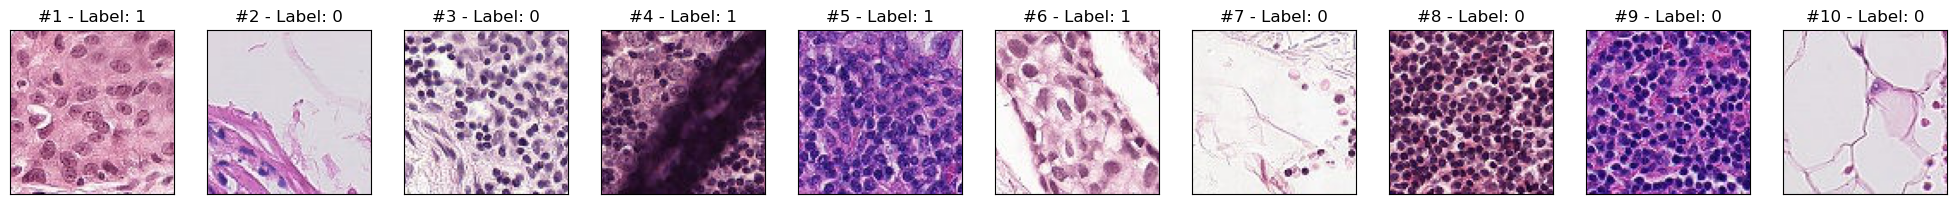

In [6]:
# print the first 10 images
fig = plt.figure(figsize=(25, 4))
for i in range(10):
    ax = fig.add_subplot(1, 10, i + 1, xticks=[], yticks=[])
    im = Image.open(folder_train + img_train[i])
    plt.imshow(im)
    label = df_train.loc[df_train['id'] == img_train[i].split('.')[0], 'label'].values[0]
    ax.set_title(f'#{i+1} - Label: {label}')

Unfortunately, I do not have the necessary domain knowledge to explain why certain pictures are labeled as positive and why some are not. But what we can see is that even positive ones among themselves differ quite alot looking at their color and structures. Interestingly, picture 5 and 9 look really similar on the first glance but they are not labeled the same. This indicates that there can be really small image features deciding whether it is a positive or negative one and our model has to recognize those tiny differences.

Next, let's investigate the images in more detail by looking at their pixel values. For this purpose, we will plot the distribution of the grayscale pixel values for the first 10 positive and negative images. 

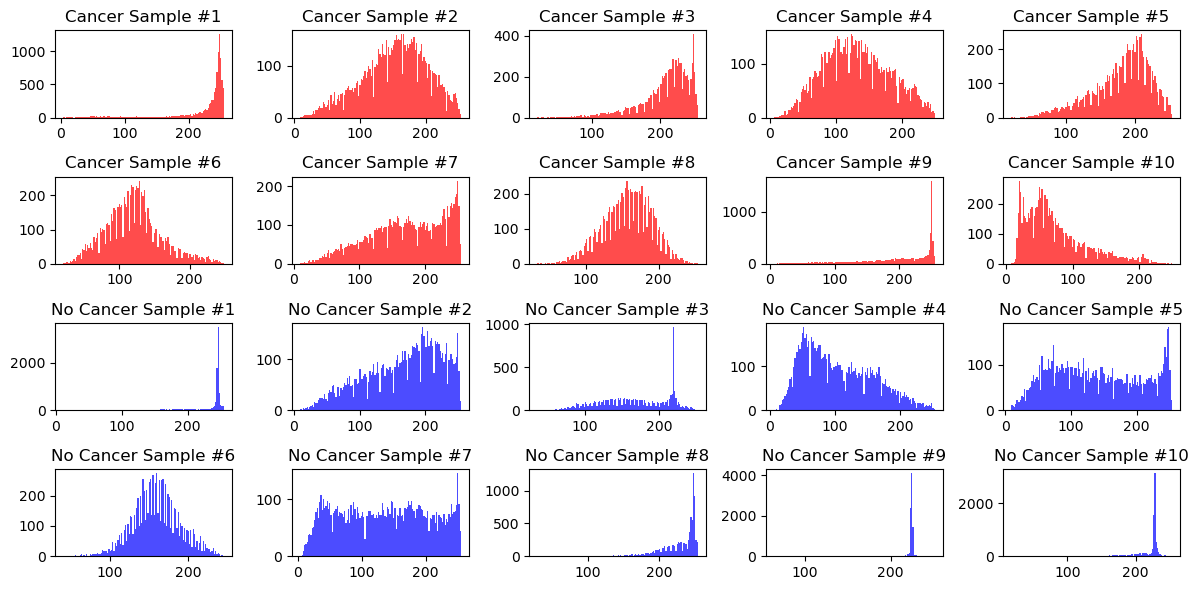

In [7]:
# sample first 10 images for both labels
cancer_samples = df_train[df_train['label'] == 1].head(10)
no_cancer_samples = df_train[df_train['label'] == 0].head(10)

# plot histograms of image pixel values for cancer and no cancer images
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(4, 5, i + 1)
    cancer_img = cv2.imread(folder_train + cancer_samples.iloc[i]['id'] + '.tif', cv2.IMREAD_GRAYSCALE)
    plt.hist(cancer_img.ravel(), bins=128, color='red', alpha=0.7)
    plt.title(f'Cancer Sample #{i+1}')
    
    plt.subplot(4, 5, i + 11)
    no_cancer_img = cv2.imread(folder_train + no_cancer_samples.iloc[i]['id'] + '.tif', cv2.IMREAD_GRAYSCALE)
    plt.hist(no_cancer_img.ravel(), bins=128, color='blue', alpha=0.7)
    plt.title(f'No Cancer Sample #{i+1}')

plt.tight_layout()
plt.show()

The upper two rows show the first 10 images labeled as positive and the the lower two rows show the first 10 images labeled as negative. Since we are only looking at the grayscale values we can only talk about images being darker (higher pixel values) or lighter (smaller pixel values). A plot like the one on the left in the third row (No Cancer Sample # 1) signals that the image mostly consists of one color with little contrast. The second plot in the first row however (Cancer Sample # 2) suggests that the image has higher contrast and different colors. We can verify this by looking back at our corresponding printed images that were labeled as positive respectively negative (#2 and #4).

With this information we could suggest the positive images typically have a higher contrast and exhibit more different colors. We count 8 positive images with high contrast and only 5 negative images with high contrast. But overall the number of samples is too small to draw a statistically relevant conclusion.  

Now, we will have a look at the label distribution to see if we are working with a balanced dataset.

In [8]:
# plot histogram of label distribution
def plot_label_dist(df):
    plt.figure(figsize=(6, 4))
    plt.hist(df['label'], bins=2, edgecolor='black', alpha=0.7)
    plt.xticks(np.arange(2), ['No Cancer', 'Cancer'])
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.title('Label Distribution')
    plt.show()

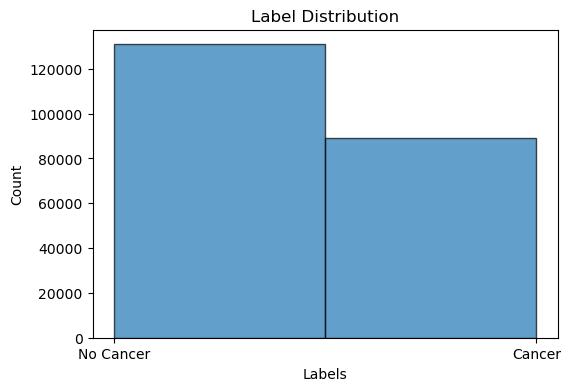

In [9]:
plot_label_dist(df_train)

In [10]:
# calculate the imbalance ratios
def calc_imbalance(df_train):
    
    df_train_cancer = df_train[df_train['label'] == 1]
    df_train_no_cancer = df_train[df_train['label'] == 0]
    
    cancer = len(df_train_cancer)
    no_cancer = len(df_train_no_cancer)

    imbalance_ratio = no_cancer / cancer
    cancer_ratio = cancer / (cancer + no_cancer)

    print("Imbalance ratio:", round(imbalance_ratio, 3))
    print("Ratio of cancer:", round(cancer_ratio, 3))

In [11]:
calc_imbalance(df_train)

Imbalance ratio: 1.469
Ratio of cancer: 0.405


Indeed, there is a remarkable imbalance present in the data that we should take care of. If we would not deal with this problem we would actually train our model to be biased and to predict 'No Cancer' most of the time. We would obtain a model that cannot predict 'Cancer' in a reliable way. In fact, there are multiple ways to deal with imbalanced data and prevent biased model performance. A few of them are:

* Resampling (Oversampling / Undersampling)
* Class Weighting during model building
* Focus other evaluation metrics

Since the evaluation metric is given by the competition we cannot change that. For this project we will use the resampling approach.

## 4.2 Balancing the Dataset

When balancing the dataset using resampling we have two choices. We could either perform oversampling by increasing the number of instances in the minority class or undersampling by reducing the number of instances in the majority class. Both options have their pros and cons. One thing to consider here is that undersampling typically reduces the risk of overfitting and focuses more on learning the minority class. All this is can be achieved at the cost of some lost information in the majority class. Now, our minority class represents the images where cancer is present and since the main interesent lies in detecting those positive cases we will apply undersampling on our data instead of oversampling.

An additional advantage that comes for free doing so, is the fact that we are safer when it comes to memory issues by dropping some of our samples. We will even reduce the training size down to 50,000 samples per label. Ultimately, to avoid potential ordering in the image files that could introduce bias into our model we randomly shuffle our final dataset.

In [12]:
# sample positive and negative images
sample_size = 50000
df_train_neg = df_train[df_train['label'] == 0].sample(sample_size, random_state=42)
df_train_pos = df_train[df_train['label'] == 1].sample(sample_size, random_state=42)

# create a new shuffeled training dataset
df_train_sample = shuffle(pd.concat([df_train_pos, df_train_neg], axis=0).reset_index(drop=True))

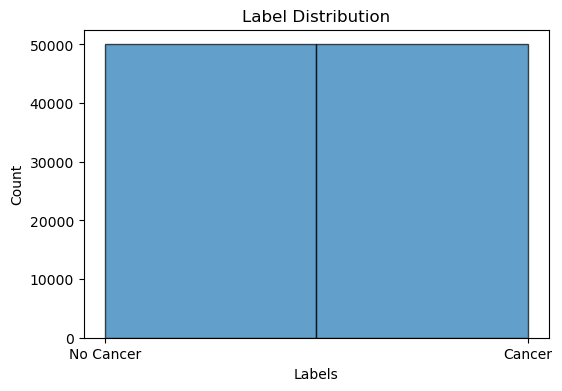

In [13]:
plot_label_dist(df_train_sample)

In [14]:
calc_imbalance(df_train_sample)

Imbalance ratio: 1.0
Ratio of cancer: 0.5


As we can see, the resulting dataset is now balanced and contains a total of 100,000 images that we will use for model building. But before we can actually build our neural networks, we have to prepare our data appropriately since we will work with the PyTorch library.

## 4.3 Plan of Analysis

Based on our EDA so far, it makes sense to use the undersampled (balanced) dataset during model building. Before we can actually start with model building there are a few necessary steps to perform.

* Data augmentation
* Normalization
* Splitting into training and validation set

Data augmentation is a technique used to artificially increase the size of a training dataset by creating new examples through various transformations. These transformations can include rotations, flips, cropping, resizing, and changes in color intensity. This helps to improve the generalization and robustness of a model by exposing it to a broader range of variations present in real-world data.

Normalization is another preprocessing step oftentimes performed in image-data related problems that involves scaling the pixel values to values on a smaller range (originally 0 to 255). This helps in stabilizing neural network training and can lead to faster and more accurate convergence of the underlying optimization algorithms.

Splitting the data into training and validation set helps us estimate how well the trained model will generalize to previously unseen data. It can also avoid overfitting by stopping the training process early if the validation performance starts to get worse. 

### 4.3.1 Data augmentation and normalization

After doing some research on the PyTorch library it becomes clear, that the data augmentation and normalization can be done using built-in features of this library. In order to avoid duplicated code (since we have to do similar things for the test data later on) we will create a custom class that wraps our dataframe in such a way that is can processed by PyTorch. We have to inherit from the 'Dataset' class and and are forced to implement the 'len' and 'getitem' methods. This is a quite similar to the Decorator pattern commonly used in software architectures.

An example can be seen here: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

In [15]:
# wrapper class for PyTorch dataset
class PyTorchData(Dataset):
    
    # set the necessary super class properties
    def __init__(self, df, folder = './', transform=None):
        super().__init__()
        self.df = df.values
        self.data_dir = folder
        self.transform = transform

    # returns the length of the dataset
    def __len__(self):
        return len(self.df)
    
    # returns the image with the given index and applies a transformation (if specified)
    def __getitem__(self, index):
        img_name,label = self.df[index]
        img_path = os.path.join(self.data_dir, img_name+'.tif')
        image = cv2.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

Now, we can define the transformations peformed during data augmentation. We will define some simple flips and rotations using the 'transforms' object from PyTorch library. After definition is done we can create a new object of our custom class by passing the transform object into the constructor.

In [16]:
transform_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(), 
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])
])

train_torch = PyTorchData(df_train_sample, folder_train, transform_train)

### 4.3.2 Data splitting

Now we will split our data into training and validation set. First, we determine the indices of the training and validation samples while using 15% of our data for validation. Then we pass them to another PyTorch object with the ability of random subset sampling. Finally we pass the previously created dataset, a batch size and the sampler to a so-called 'DataLoader'.

The 'DataLoader' allows us to access features and labels of our dataset on a per-sample basis. During model training, it's common to work with samples in minibatches, shuffle data per epoch to mitigate overfitting, and leverage Python's multiprocessing to accelerate data retrieval. The 'DataLoader' simplifies this process for us.

In [17]:
batch_size = 128

# set training and validation indices 
indices = list(range(len(train_torch)))
split = int(np.floor(0.15 * len(train_torch)))
train_idx, valid_idx = indices[split:], indices[:split]

# random samplers
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders
train_loader = DataLoader(train_torch, batch_size=batch_size, sampler=train_sampler)
valid_loader = DataLoader(train_torch, batch_size=batch_size, sampler=valid_sampler)

### 4.3.3 Preparing test data

After setting up our training data, we perform similar steps to prepare our test data. Of course this time we do not need to split the data or apply any transformations like rotation or flipping. By using the sample submission CSV file we get access to all the image ID's while still having a dataframe format. 

In [18]:
transform_test = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])
])

test_torch = PyTorchData(df_sample_sub, folder_test, transform_test)
test_loader = DataLoader(test_torch, batch_size=batch_size, shuffle=False)

# 5. Model Building and Hyperparameter Tuning

## 5.1 Basic CNN model

First, we will check whether we can run our neural networks on a GPU. This will help to reduce computing time.

In [19]:
clear_memory()

In [20]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Device: ", device)

Device:  cuda:0


Next, we define our network structure. The first layer captures the 32 pixels as required by the competition. The following architecture consists of several convolutional blocks with increasing numbers of channels, followed by a fully connected section for classification. Batch normalization and ReLU activation functions are used to enhance training stability and convergence. Max-pooling is used to reduce spatial dimensions, and dropout is applied to reduce overfitting.

In [21]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 32, 3, stride=1, padding=1),
                        nn.BatchNorm2d(32),
                        nn.ReLU(inplace=True),
                        nn.MaxPool2d(2,2))
        
        self.conv2 = nn.Sequential(
                        nn.Conv2d(32, 64, 3, stride=1, padding=1),
                        nn.BatchNorm2d(64),
                        nn.ReLU(inplace=True),
                        nn.MaxPool2d(2,2))
        
        self.conv3 = nn.Sequential(
                        nn.Conv2d(64, 128, 3, stride=1, padding=1),
                        nn.BatchNorm2d(128),
                        nn.ReLU(inplace=True),
                        nn.MaxPool2d(2,2))
        
        self.conv4 = nn.Sequential(
                        nn.Conv2d(128, 256, 3, stride=1, padding=1),
                        nn.BatchNorm2d(256),
                        nn.ReLU(inplace=True),
                        nn.MaxPool2d(2,2))
        
        self.conv5 = nn.Sequential(
                        nn.Conv2d(256, 512, 3, stride=1, padding=1),
                        nn.BatchNorm2d(512),
                        nn.ReLU(inplace=True),
                        nn.MaxPool2d(2,2))
        
        
        self.fc=nn.Sequential(
                nn.Linear(512*3*3, 256),
                nn.ReLU(inplace=True),
                nn.BatchNorm1d(256),
                nn.Dropout(0.4),
                nn.Linear(256, 1))
        
    def forward(self,x):
        x=self.conv1(x)
        x=self.conv2(x)
        x=self.conv3(x)
        x=self.conv4(x)
        x=self.conv5(x)
        x=x.view(x.shape[0],-1)
        x=self.fc(x)
        return x

In [22]:
# create CNN
model = CNN().to(device)
print(model)

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), p

We perform a manual hyperparameter tuning on the learning rate. In order to stay within computation time limits, we will only look at the three different values listed below. For the same reason we will only iterate over 10 epochs. We use a binary cross-entropy loss function.

In [23]:
# hyperparameters to tune
learning_rates = [0.001, 0.0005, 0.0002]

In [24]:
# save final results
results = []
best_model_idx = None
best_auc = 0.0
best_model_cnn = None

# iterate all values for the hyperparameter
for idx, lr in enumerate(learning_rates):
    
    # use GPU if available
    model = CNN().to(device)
    
    # define optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()

    # save results over epochs 
    train_losses = []
    valid_losses = []
    valid_aucs = []   
    n_epochs = 10

    # iterate all epochs
    for epoch in range(1, n_epochs+1):
        
        valid_aucs_epoch = [] 
        model.train()
        train_loss = 0.0
        
        # process the training images
        for data, target in train_loader:
            optimizer.zero_grad()
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output.view(-1), target.float())
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * data.size(0)
        
        model.eval()
        valid_loss = 0.0
        
        # process the validation images
        for data, target in valid_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output.view(-1), target.float())
            valid_loss += loss.item() * data.size(0)
            y_actual = target.data.cpu().numpy()
            y_pred = torch.sigmoid(output).detach().cpu().numpy()
            valid_aucs_epoch.append(roc_auc_score(y_actual, y_pred))
        
        # determine values for current epoch
        train_loss /= len(train_loader.sampler)
        valid_loss /= len(valid_loader.sampler)
        valid_auc = np.mean(valid_aucs_epoch)
        
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        valid_aucs.append(valid_auc)

        print('Learning Rate: {:.6f} | Epoch: {} | Training Loss: {:.6f} | Validation Loss: {:.6f} | Validation AUC: {:.4f}'.format(lr, epoch, train_loss, valid_loss, valid_auc))
    
    # save results for current value of hyperparameter
    results.append({'learning_rate': lr, 'train_losses': train_losses, 'valid_losses': valid_losses, 'valid_aucs': valid_aucs})
    
    # save best model
    avg_auc = np.mean(valid_aucs)
    if avg_auc > best_auc:
        best_auc = avg_auc
        best_model_idx = idx
        best_model_cnn = model
    
# print best hyperparameter
print("Best learning rate according to hyperparameter search: ", learning_rates[best_model_idx])

Learning Rate: 0.001000 | Epoch: 1 | Training Loss: 0.376495 | Validation Loss: 0.605371 | Validation AUC: 0.9366
Learning Rate: 0.001000 | Epoch: 2 | Training Loss: 0.297403 | Validation Loss: 0.292150 | Validation AUC: 0.9582
Learning Rate: 0.001000 | Epoch: 3 | Training Loss: 0.257397 | Validation Loss: 0.489946 | Validation AUC: 0.9202
Learning Rate: 0.001000 | Epoch: 4 | Training Loss: 0.244352 | Validation Loss: 0.253805 | Validation AUC: 0.9654
Learning Rate: 0.001000 | Epoch: 5 | Training Loss: 0.244890 | Validation Loss: 0.206166 | Validation AUC: 0.9764
Learning Rate: 0.001000 | Epoch: 6 | Training Loss: 0.213844 | Validation Loss: 0.329192 | Validation AUC: 0.9716
Learning Rate: 0.001000 | Epoch: 7 | Training Loss: 0.205420 | Validation Loss: 0.484399 | Validation AUC: 0.9543
Learning Rate: 0.001000 | Epoch: 8 | Training Loss: 0.198450 | Validation Loss: 0.313692 | Validation AUC: 0.9729
Learning Rate: 0.001000 | Epoch: 9 | Training Loss: 0.185807 | Validation Loss: 0.211712

Let's plot the results.

In [25]:
# plot training and validation loss over epochs for best model
def plot_losses(train_losses, valid_losses, title):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(valid_losses, label="Valid Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.show()

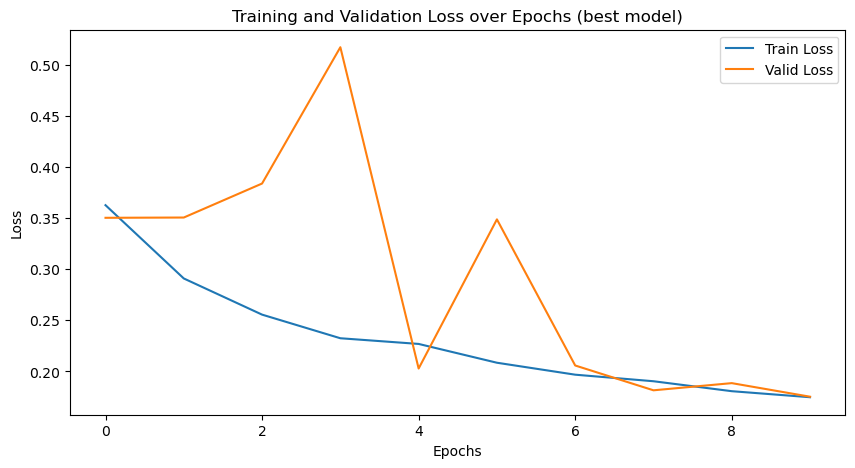

In [26]:
best_result = results[best_model_idx]
plot_losses(best_result['train_losses'], best_result['valid_losses'], 'Training and Validation Loss over Epochs (best model)')

In [27]:
# plot validation auc over epochs for best model
def plot_aucs(aucs, title):
    plt.figure(figsize=(10, 5))
    plt.plot(aucs, label="Validation AUC")
    plt.xlabel('Epochs')
    plt.ylabel('Validation AUC')
    plt.title(title)
    plt.legend()
    plt.show()

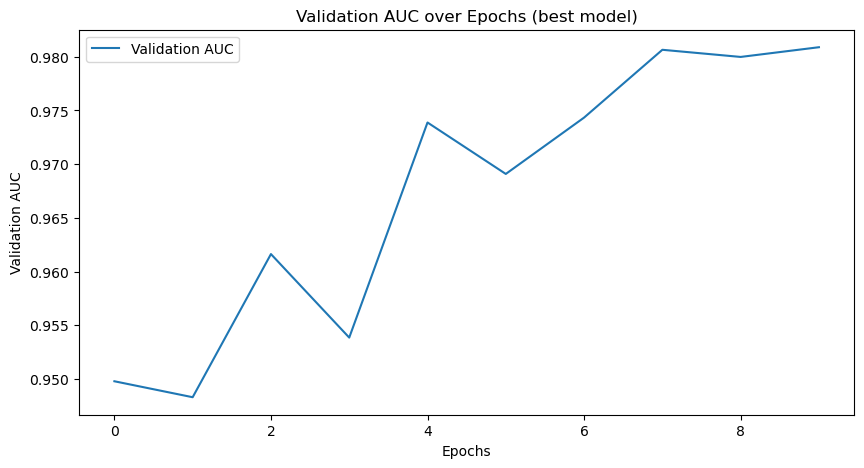

In [28]:
best_result = results[best_model_idx]
plot_aucs(best_result['valid_aucs'], 'Validation AUC over Epochs (best model)')

The results seem to be reasonable and pretty good. We will discuss the results in more detail in the next section. But before, we will try out another model architecture.

## 5.2 Dense (Pretrained) Network

For our second model, we do not perform a hyperparameter search again since the whole notebook would need too much GPU time. Therefore, we reuse the previously found best learning rate of our first CNN architecture. For the same reason we also perform only 10 epochs as with our first model. And the same as before, we use a binary cross-entropy loss function.

The main difference will be that we now build our architecture upon a given pretrained dense network architecture where each layer is connected to every other layer in a feed-forward fashion. For each layer, the feature-maps of all preceding layers are used as inputs, and its own feature-maps are used as inputs into all subsequent layers. DenseNets have several advantages compared to standard CNNs. They mitigate the vanishing-gradient problem, and reduce the number of parameters to name just a few.

In [29]:
clear_memory()

In [30]:
class DenseNetModified(nn.Module):
    def __init__(self):
        super(DenseNetModified, self).__init__()
        
        # use a pretrained dense net architecture
        self.densenet = models.densenet121(pretrained=True)
        
        num_features = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 1)
        )
        
    def forward(self, x):
        return self.densenet(x)

In [31]:
# reuse best learning rate from first CNN
lr = learning_rates[best_model_idx]
model_dense = DenseNetModified().to(device)

# set optimizer and loss function
optimizer = optim.Adam(model_dense.parameters(), lr=lr)
criterion = nn.BCEWithLogitsLoss()

# store final results
train_losses_dense = []
valid_losses_dense = []
valid_aucs_dense = []
n_epochs = 10

# iterate all epochs
for epoch in range(1, n_epochs+1):

    valid_aucs_epoch = [] 
    model_dense.train()
    train_loss = 0.0
 
    # process training images
    for data, target in train_loader:
        optimizer.zero_grad()
        data, target = data.to(device), target.to(device)
        output = model_dense(data)
        loss = criterion(output.view(-1), target.float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)

    model_dense.eval()
    valid_loss = 0.0

    # process validation images
    for data, target in valid_loader:
        data, target = data.to(device), target.to(device)
        output = model_dense(data)
        loss = criterion(output.view(-1), target.float())
        valid_loss += loss.item() * data.size(0)
        y_actual = target.data.cpu().numpy()
        y_pred = torch.sigmoid(output).detach().cpu().numpy()
        valid_aucs_epoch.append(roc_auc_score(y_actual, y_pred))

    # store final results
    train_loss /= len(train_loader.sampler)
    valid_loss /= len(valid_loader.sampler)
    valid_auc = np.mean(valid_aucs_epoch)

    train_losses_dense.append(train_loss)
    valid_losses_dense.append(valid_loss)
    valid_aucs_dense.append(valid_auc)

    print('Learning Rate: {:.6f} | Epoch: {} | Training Loss: {:.6f} | Validation Loss: {:.6f} | Validation AUC: {:.4f}'.format(lr, epoch, train_loss, valid_loss, valid_auc))

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 167MB/s]


Learning Rate: 0.000500 | Epoch: 1 | Training Loss: 0.230133 | Validation Loss: 0.174652 | Validation AUC: 0.9807
Learning Rate: 0.000500 | Epoch: 2 | Training Loss: 0.176625 | Validation Loss: 0.169718 | Validation AUC: 0.9824
Learning Rate: 0.000500 | Epoch: 3 | Training Loss: 0.164841 | Validation Loss: 0.152952 | Validation AUC: 0.9857
Learning Rate: 0.000500 | Epoch: 4 | Training Loss: 0.147867 | Validation Loss: 0.169702 | Validation AUC: 0.9825
Learning Rate: 0.000500 | Epoch: 5 | Training Loss: 0.138817 | Validation Loss: 0.175191 | Validation AUC: 0.9834
Learning Rate: 0.000500 | Epoch: 6 | Training Loss: 0.131652 | Validation Loss: 0.142231 | Validation AUC: 0.9874
Learning Rate: 0.000500 | Epoch: 7 | Training Loss: 0.125433 | Validation Loss: 0.125476 | Validation AUC: 0.9897
Learning Rate: 0.000500 | Epoch: 8 | Training Loss: 0.126278 | Validation Loss: 0.123520 | Validation AUC: 0.9901
Learning Rate: 0.000500 | Epoch: 9 | Training Loss: 0.115444 | Validation Loss: 0.115052

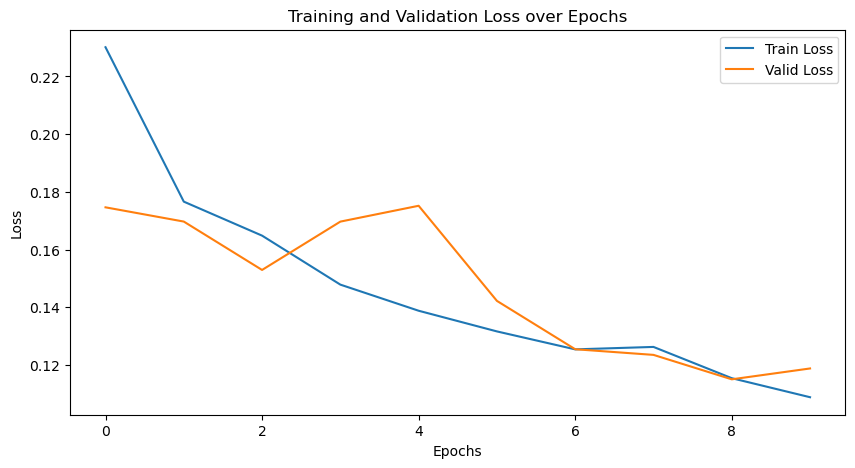

In [32]:
plot_losses(train_losses_dense, valid_losses_dense, 'Training and Validation Loss over Epochs')

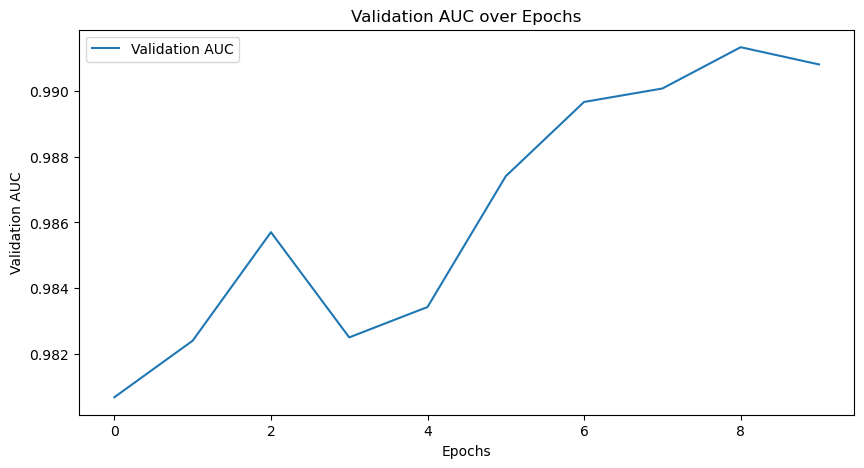

In [33]:
plot_aucs(valid_aucs_dense, 'Validation AUC over Epochs')

Again the results seem to be quite good. Let's dive into the last section where we discuss the results in detail and compare our two model architectures.

# 6. Results and Analysis

## 6.1 Model summary and comparison

As we have already seen both of our models seem to work quite well on the training data. Now, it's time to compare them and select the better one for predicting on the test data. First, lets have a closer look at the training and validation losses.

As a reminder, we did a hyperparameter tuning on the learning rate for the first model where we tried out three different values. The best one selected was the following.

In [34]:
print("Best learning rate according to hyperparameter search on Classic CNN model: ", learning_rates[best_model_idx])

Best learning rate according to hyperparameter search on Classic CNN model:  0.0005


In order to stay within computation time limits we reused this value for the second dense net model. Now, let's compare the losses of our two models.

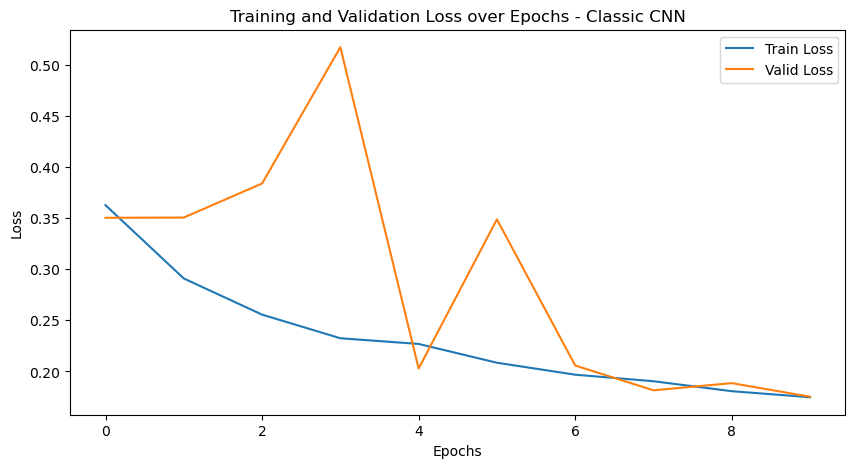

In [35]:
plot_losses(best_result['train_losses'], best_result['valid_losses'], 'Training and Validation Loss over Epochs - Classic CNN')

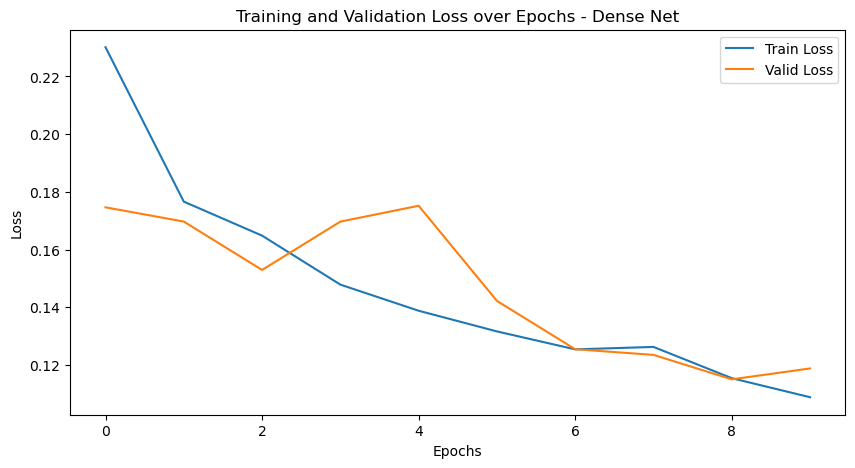

In [36]:
plot_losses(train_losses_dense, valid_losses_dense, 'Training and Validation Loss over Epochs - Dense Net')

The first plot shows the classic CNN architecture. We observe a decreasing training loss as the epoch number increases which is what we would expect. The validation loss looks more unsteady but overall also decreases when reaching the higher epoch numbers. As already mentioned, we could potentially improve here if we would allow for more epochs. But since there is time limit on Kaggle for using the GPU we restrict ourselves a little bit for this project.

The second architecture clearly shows better results. Already after the first epoch there is remarkable difference in training loss, which means the dense network architecture works much better. The same can be said about higher epochs. We constantly get smaller loss values. The reason for the better performance is probably the fact that the connected layer structure of the network can capture more complex patterns in the dataset as compared to the classic CNN structure. Also the fact that the dense network is pretrained gives the model a headstart and helps to optimize faster.

Let's see if our dense model also outperforms when looking at the AUC scores.

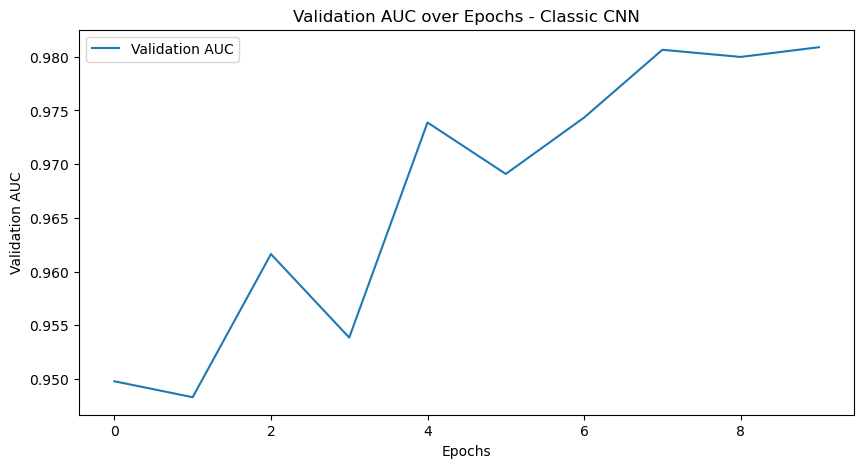

In [37]:
plot_aucs(best_result['valid_aucs'], 'Validation AUC over Epochs - Classic CNN')

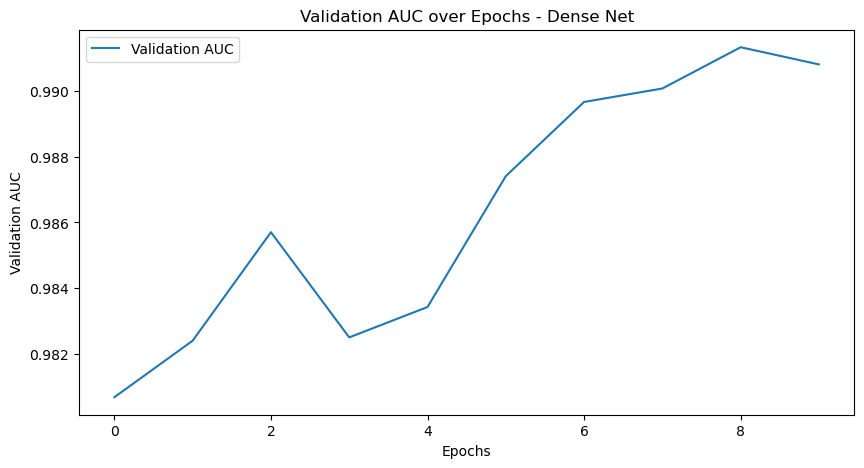

In [38]:
plot_aucs(valid_aucs_dense, 'Validation AUC over Epochs - Dense Net')

Now looking at the AUC scores we can basically conclude the same. The first model shows good results and an increasing score over the epochs. Similar to the losses the dense structure starts out at better values than the classic CNN. Even if the increase over epochs is not as significant as with the first model, the absolute values are still slightly higher.

Summarizing the final results everything seems to be pretty easy. But of course, there were some problems during model building and training, e.g. computing time limits, understanding model architectures, and debugging the training process. We will talk about these topics later on in the Learnings and Takeaways section.

## 6.2 Predicting on test data

We have seen that the dense model performed the best. We will use it now to predict on the test data and create our submission file.

In [39]:
clear_memory()

In [40]:
# turn of gradients
model_dense.eval()
preds = []

# iterate all test images
for batch_i, (data, target) in enumerate(test_loader):
    data, target = data.to(device), target.to(device)
    output = model_dense(data)

    pr = output.detach().cpu().numpy()
    for i in pr:
        preds.append(i)

# add predicted labels to submission file    
df_sample_sub['label'] = preds

In [41]:
# convert probabilities to float
for i in range(len(df_sample_sub)):
    df_sample_sub.label[i] = np.float(df_sample_sub.label[i]) 

In [42]:
# create submission file
df_sample_sub.to_csv('submission.csv', index=False)

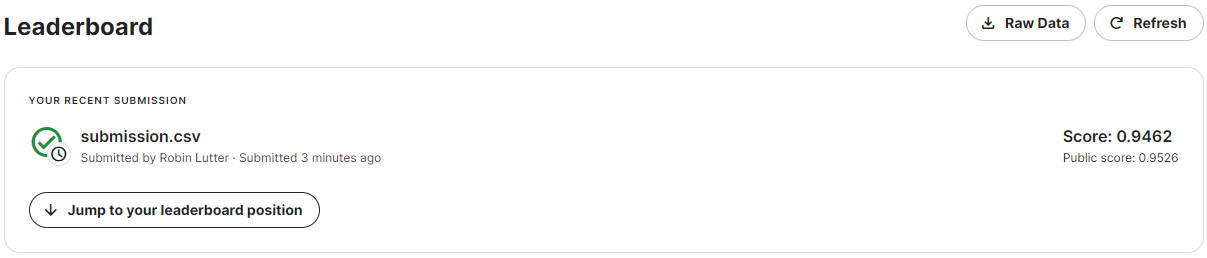

Submitting the resulting CSV file, we get a final leaderboard score shown in the screenshot above which is a solid result for this project! Unfortunately, I could not make a screenshot of my exact leaderboard position since the button that makes me jump to that position did not work properly. 

# 7. Conclusion

## 7.1 Result Summary

As we have already seen in the previous section, the dense network performed better than the CNN network because of its ability to capture more complex structures in our images. However, both models did a good job on the training data. Looking at the performance of the dense network on the test data we saw that we obtain a really good final score.

## 7.2 Learnings and Takeaways

Working with neural networks requires a different style of work compared to simpler supervised learning techniques like regression analysis. Getting results from model training might last several hours. Therefore, it is really important to work clean and precise so that you avoid having many training iterations. One aspect that might be underestimated but helped me a lot during this project is the usage of print statements in the code. This way you can debug your code better, inspect intermediate results and find errors more easily. Besides that aspect, image data in particalur requires quite different preprocessing steps compared to e.g. textual data. Techniques like image augmentation can really improve your model if used correctly.

Another problem I encountered during my work was the memory limitations of the GPU on Kaggle. On way to solve this issue was to reduce the batch size from 256 down to 128 which leads to less RAM consumptions during training and evaluating. Additionaly, I had to call the garbage collector from time to time in order to free unused memory.

## 7.3 What didn't work

Overall, everything worked quite well. However, it would have been great to work with more epochs in order to get more precise results. The limited GPU memory really was a problem in this project since image data requires so much disk space. It took quite a few iterations to find suitable values for the number of included images, the batch size or number of epochs while still getting meaningful results. 

## 7.4 Possible improvements

One possible improvement would be to include the whole image set instead of just a smaller amount due to memory issues. Also using more epochs would possibly enhance model performance. It might be also interesting to see how much better the model would perform with a balanced image set compared to the original unbalanced one.

If we had enough computing power, we could also expand our hyperparameter tuning by including more parameters and a wider value range.